In [1]:
# Add gis packages to colab environment
!pip install geopandas
!apt-get install -y libspatialindex-dev
!pip install rtree

# Then import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

     |████████████████████████████████| 1.0MB 16.9MB/s 
     |████████████████████████████████| 6.5MB 42.9MB/s 
     |████████████████████████████████| 15.3MB 279kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ub

In [4]:
from google.colab import drive
drive.mount('/content/gdrive') # connects Colab to your Google Drive
root_path = 'gdrive/My Drive/gis/' # set root path to folder where you uploaded the data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Read in PUDs file as a geodataframe and initialize coordinate reference system (CRS)
puds = gpd.read_file(root_path+'input/Planned_Unit_Development_(PUDs).shp', crs = {'init' :'epsg:4326'})
aff = pd.read_csv(root_path+'input/Affordable_Housing.csv')
crosswalk = pd.read_csv(root_path+'input/zoning_crosswalk.csv')

In [7]:
# Running this code grabs rows from the first 3 index places (4 rows total!)
puds.sample(3)

,OBJECTID,PUD_NAME,PUD_WEB_UR,PUD_CHANGE,PUD_ZONING,PUD_STATUS,PUD_CASE_N,GLOBALID,WARD,SHAPEAREA,SHAPELEN,geometry
52,187229,Gonzaga,https://app.dcoz.dc.gov/Content/Search/ViewCas...,"Official Digital Zoning Map of July 1, 2010",C-3-C,Final,89-14,{6DC97781-75F1-4569-8FE5-FC93133C7422},Ward 6,0,0,"POLYGON ((-77.00952 38.90069, -77.00928 38.900..."
268,187445,Jemals Hechts LLC,https://app.dcoz.dc.gov/Content/Search/ViewCas...,"Set Down 2/24/14, Approved July 17, 2015",C-3-C,Final,14-01A,{0E6CC5F4-EC69-4FC6-8432-832F077B22C1},Ward 5,0,0,"POLYGON ((-76.98503 38.91550, -76.98392 38.915..."
155,187332,3910 Georgia Ave. Associates et al.,https://app.dcoz.dc.gov/Content/Search/ViewCas...,Minor Modification 2/28/2011,C-3-A,Final,08-08A,{DA2A18E7-2757-4DE3-8DDE-CD3011EF058B},Ward 4,0,0,"POLYGON ((-77.02588 38.93901, -77.02589 38.939..."


In [8]:
# This gives you a summary of what is within the Affordable housing .csv
aff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   X                              558 non-null    float64
 1   Y                              558 non-null    float64
 2   OBJECTID                       558 non-null    int64  
 3   MAR_WARD                       558 non-null    object 
 4   ADDRESS                        555 non-null    object 
 5   PROJECT_NAME                   558 non-null    object 
 6   STATUS_PUBLIC                  558 non-null    object 
 7   AGENCY_CALCULATED              558 non-null    object 
 8   TOTAL_AFFORDABLE_UNITS         558 non-null    int64  
 9   LATITUDE                       555 non-null    float64
 10  LONGITUDE                      555 non-null    float64
 11  AFFORDABLE_UNITS_AT_0_30_AMI   558 non-null    int64  
 12  AFFORDABLE_UNITS_AT_31_50_AMI  558 non-null    int

In [9]:
# This gives you a summary of what is within the PUD .shp file
puds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    302 non-null    int64   
 1   PUD_NAME    302 non-null    object  
 2   PUD_WEB_UR  302 non-null    object  
 3   PUD_CHANGE  300 non-null    object  
 4   PUD_ZONING  302 non-null    object  
 5   PUD_STATUS  302 non-null    object  
 6   PUD_CASE_N  302 non-null    object  
 7   GLOBALID    302 non-null    object  
 8   WARD        301 non-null    object  
 9   SHAPEAREA   302 non-null    int64   
 10  SHAPELEN    302 non-null    int64   
 11  geometry    302 non-null    geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 28.4+ KB


In [10]:
# Create a geometry column in the affordable housing dataframe
aff['geometry'] = aff.apply(lambda row: Point(row.X, row.Y), axis=1)
aff = gpd.GeoDataFrame(aff, crs={'init' :'epsg:4326'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
aff.sample(1) #sampling to the first index... or column headers and one row.

,X,Y,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,LONGITUDE,AFFORDABLE_UNITS_AT_0_30_AMI,AFFORDABLE_UNITS_AT_31_50_AMI,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry
91,-76.983039,38.866136,1678,Ward 8,"1916 15th Street Southeast, Washington, Distri...",1916 15th St SE,Under Construction,DHCD,0,38.866129,-76.983037,0,0,0,0,0,NaN,54043.0,401472.15,133145.46,1916 15TH STREET SE,2021/05/03 04:01:24+00,POINT (-76.98304 38.86614)


In [12]:
# Use geospatial join to identify which PUDs include affordable housing projects
puds_aff = gpd.sjoin(puds, aff, op='intersects', how='left')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  


In [13]:
# Check our Merge - incremental development, we're checking as we go!
puds_aff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 310 entries, 0 to 301
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID_left                  310 non-null    int64   
 1   PUD_NAME                       310 non-null    object  
 2   PUD_WEB_UR                     310 non-null    object  
 3   PUD_CHANGE                     308 non-null    object  
 4   PUD_ZONING                     310 non-null    object  
 5   PUD_STATUS                     310 non-null    object  
 6   PUD_CASE_N                     310 non-null    object  
 7   GLOBALID                       310 non-null    object  
 8   WARD                           309 non-null    object  
 9   SHAPEAREA                      310 non-null    int64   
 10  SHAPELEN                       310 non-null    int64   
 11  geometry                       310 non-null    geometry
 12  index_right                 

In [14]:
# Merge dataframe with zoning categories crosswalk
puds_info = puds_aff.merge(crosswalk[['Zone_Cat']], how='left', left_on='PUD_ZONING', right_on=crosswalk['Zone'])

In [15]:
# Quick count using print statements to show us how many PUDs there are total, and how many offer affordable housing.

print(f"Total count of PUDs: {puds_info.shape[0]}")
print(f"Count PUDs offering Affordable Housing: {puds_info.loc[~puds_info.PROJECT_NAME.isna()].shape[0]}")

Total count of PUDs: 310
Count PUDs offering Affordable Housing: 83


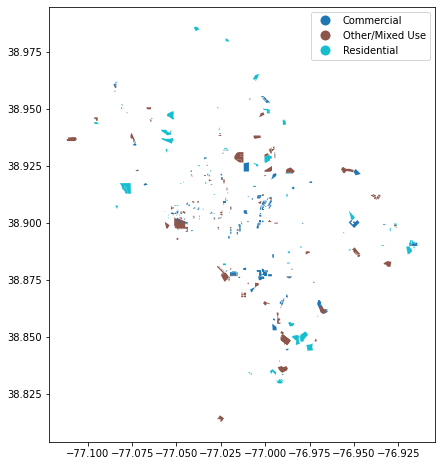

In [16]:
# Create a map of PUDs by Zoning Category
puds_info.plot(column='Zone_Cat', legend=True, figsize=(16,8));


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


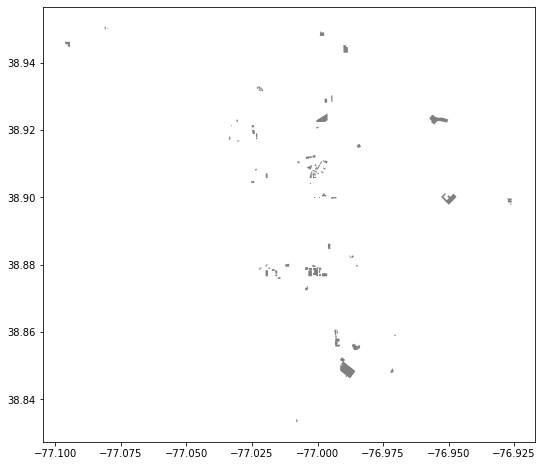

In [17]:
# Create a map of just the PUDs that provide Affordable Housing
puds_info[puds_info['TOTAL_AFFORDABLE_UNITS']>0].plot(column='TOTAL_AFFORDABLE_UNITS', color='grey', figsize=(16,8));

In [18]:
# Export geodataframe as shapefile within Colab environment
puds_info.to_file('puds_info.shp')

# Copy shapefile components from Colab environment to Google Drive using bash script
!cp puds_info.cpg 'gdrive/My Drive/gis/output'
!cp puds_info.dbf 'gdrive/My Drive/gis/output'
!cp puds_info.prj 'gdrive/My Drive/gis/output'
!cp puds_info.shp 'gdrive/My Drive/gis/output'
!cp puds_info.shx 'gdrive/My Drive/gis/output'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  
